## Technical scripts loading

In [247]:
source('packages.r')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Warning message in install.packages("xgboost"):
“installation of package ‘xgboost’ had non-zero exit status”Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is uns

In [53]:
source('helpers.r')

### Data preparation

Loading the dataset and creating index column: 'idx'

In [4]:
df  <- read.csv('creditcard.csv')
idx <- c(1:nrow(df))
df  <- cbind(idx,df)

In [4]:
head(df)

idx,Time,V1,V2,V3,V4,V5,V6,V7,V8,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
2,0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
3,1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
4,1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
5,2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
6,2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


Transforming 'Time' column to show second of day

In [5]:
time    <- df$Time
time    <- ifelse(time>=86400,time-86400,time)
df$Time <- time

Transforming 'Class' column to factor

In [8]:
df$Class <- as.factor(df$Class)

Simple statistics of the dataset

In [9]:
summary(df)

      idx              Time             V1                  V2           
 Min.   :     1   Min.   :    0   Min.   :-56.40751   Min.   :-72.71573  
 1st Qu.: 71202   1st Qu.:38154   1st Qu.: -0.92037   1st Qu.: -0.59855  
 Median :142404   Median :54039   Median :  0.01811   Median :  0.06549  
 Mean   :142404   Mean   :52337   Mean   :  0.00000   Mean   :  0.00000  
 3rd Qu.:213606   3rd Qu.:69587   3rd Qu.:  1.31564   3rd Qu.:  0.80372  
 Max.   :284807   Max.   :86398   Max.   :  2.45493   Max.   : 22.05773  
       V3                 V4                 V5                   V6          
 Min.   :-48.3256   Min.   :-5.68317   Min.   :-113.74331   Min.   :-26.1605  
 1st Qu.: -0.8904   1st Qu.:-0.84864   1st Qu.:  -0.69160   1st Qu.: -0.7683  
 Median :  0.1799   Median :-0.01985   Median :  -0.05434   Median : -0.2742  
 Mean   :  0.0000   Mean   : 0.00000   Mean   :   0.00000   Mean   :  0.0000  
 3rd Qu.:  1.0272   3rd Qu.: 0.74334   3rd Qu.:   0.61193   3rd Qu.:  0.3986  
 Max.   

As it can be seen from the barplot below, the classes of non-frauds: 0 and frauds: 1. <br> <b> The dataset is strongly unbalanced. </b>

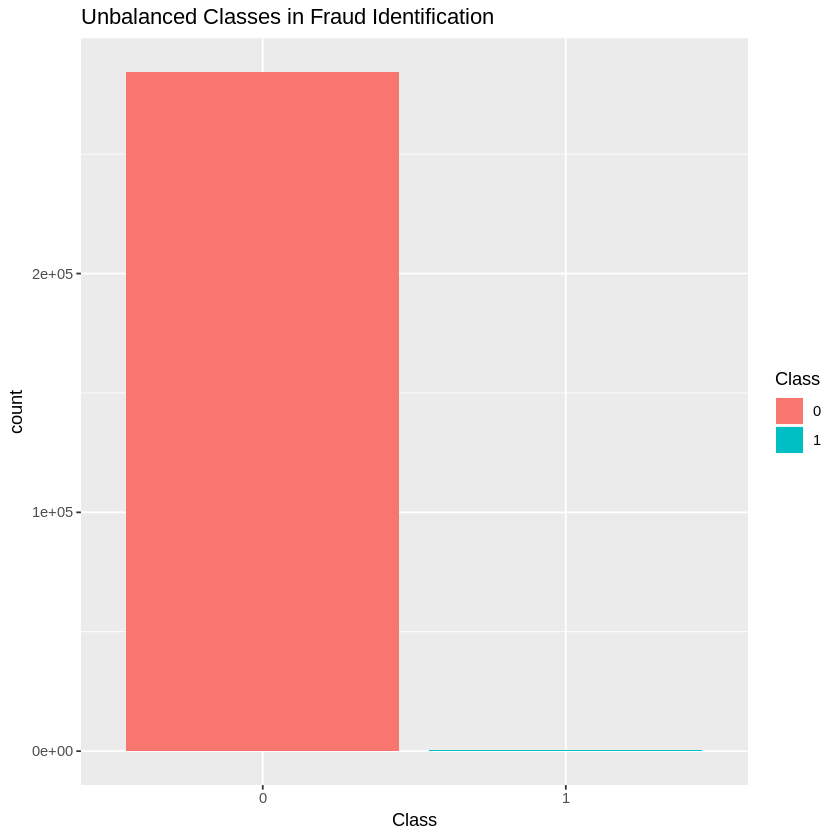

In [32]:
ggplot(df, aes(Class,fill=Class))+
    geom_bar()+
    labs(title = "Unbalanced Classes in Fraud Identification")

Therefore this kind of analysis should be treated as an anomaly detection. One may imagine that there are load of non-fraud transactions that follow some kind of a pattern and all of the fraud transactions can be some kind of of outlier observations. 

However from the below scatter plot, using two first PCs (which are explaining the variance at most), there is no distinctive pattern between legal and fraudulent transactions.

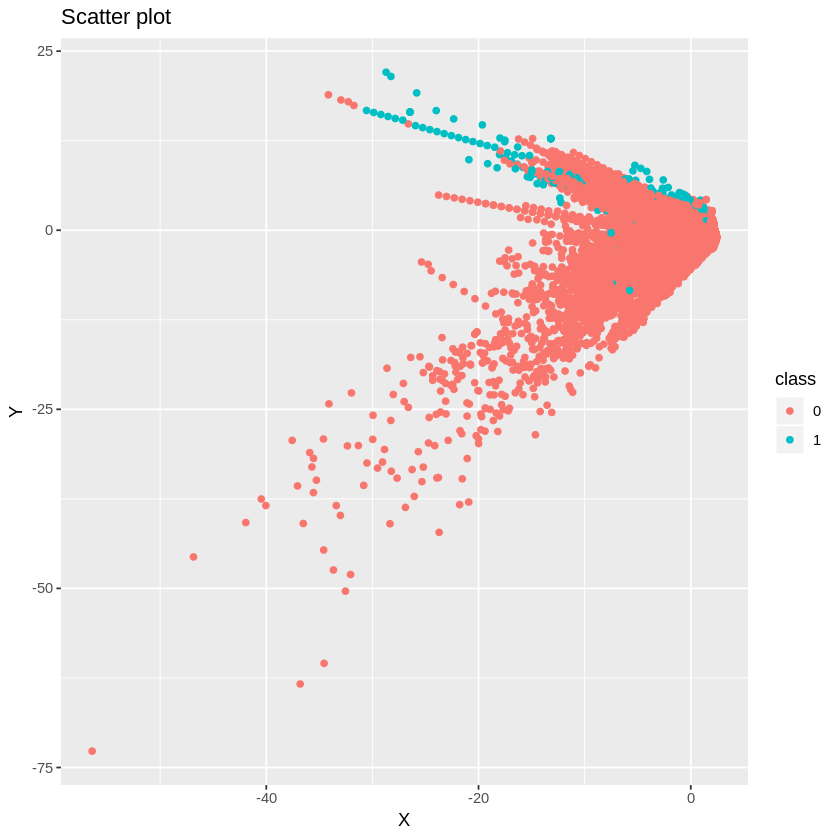

In [62]:
scatter(df,df$V1,df$V2,df$Class)

### Random Forest - features pre-selection

Nevertheless, each transaction is described with 28 PCs. <br> In order to find components thay are more likely to discrimnate between the two classes a simple Random Forest has been built to automatically find important features.

The dataset has been randomly divided into train and validation data with ratio 2:1.

In [73]:
sets_list <- train_valid_div(df,0.66,'idx')
train <- sets_list[["train"]]
valid <- sets_list[["valid"]]

In [74]:
train <- train %>% select(-idx,-Amount)
valid <- valid %>% select(-idx,-Amount)

Training the simplest RF regression model. With default parameters.

In [75]:
feat_imp_rf <- randomForest(Class ~ ., data=train)

Summary of RF classification:

In [77]:
print(feat_imp_rf)


Call:
 randomForest(formula = Class ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 0.05%
Confusion matrix:
       0   1  class.error
0 187614  18 9.593246e-05
1     71 270 2.082111e-01


The below plot presents importance of variables by the Mean Gini Decrease. <br> It shows which variables are contributing the most in overall Gini decrease. The less the gini index is the better predicitve abilities of the more are.

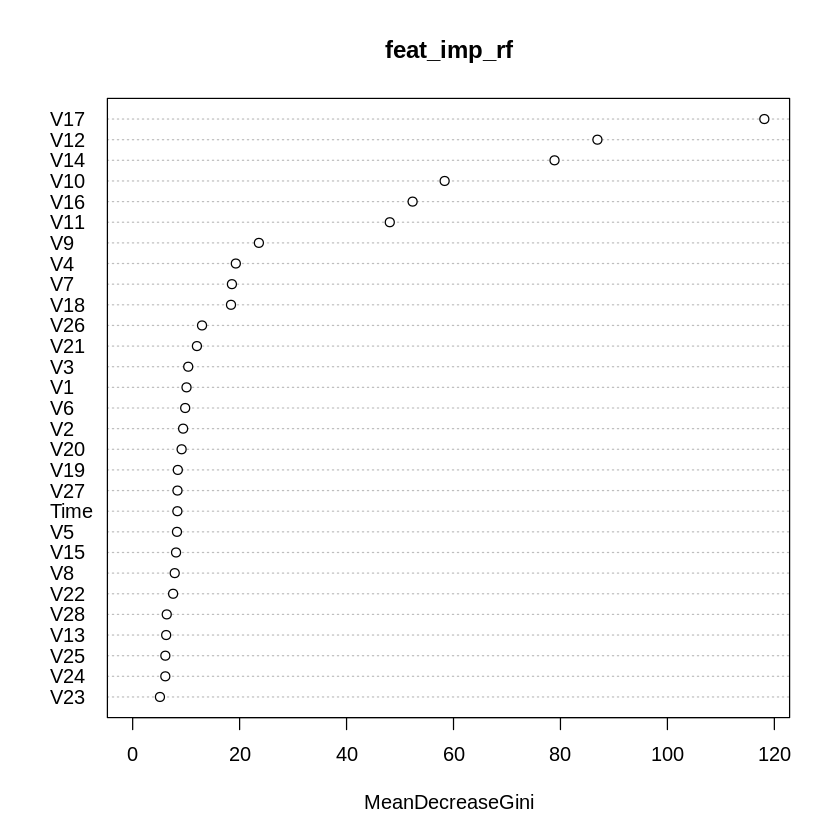

In [78]:
varImpPlot(feat_imp_rf)

Standard procedure assumes that if more than 50% of trees voted for a specific class then this class shoulb be predicted by the model. <br> However, especially in the case of such unbalanced data it is important to check different cut-off points versus the metric of interest.

In [92]:
cutoff <- cutoff_exam(feat_imp_rf,train$Class,0.05,0.95)

In [96]:
opt_th <- cutoff[['opt_th']]
cutoff[['results']]

,threshold,recall,precision,f1
res,0.05,0.8621701,0.5664740,0.6837209
res,0.10,0.8563050,0.7373737,0.7924016
res,0.15,0.8504399,0.8055556,0.8273894
res,0.20,0.8475073,0.8450292,0.8462665
res,0.25,0.8416422,0.8618619,0.8516320
res,0.30,0.8299120,0.8816199,0.8549849
res,0.35,0.8269795,0.8952381,0.8597561
res,0.40,0.8123167,0.9081967,0.8575851
res,0.45,0.8005865,0.9161074,0.8544601
res,0.50,0.7917889,0.9375000,0.8585056


As we may see basing on maximum value for F-1 the value of 0.35 is the optimal one. <br> <b>For training we may observe @0.35:</b> <br> Recall: 82.70% <br> Precision: 89.52% <br> F-1: 85.98% <br> In case of detecting credi card frauds it is important to balance between Preicision and Recall, we want to achieve relatively high metrics. We do not want to skip many actual frauds (Recall) and do not want to consume time on investigations on non-frauds (Precision). The F-1 score combines both of those values and gives us pperspective on both metrics at the same time. The this why we will focus on F-1 while doing the model.

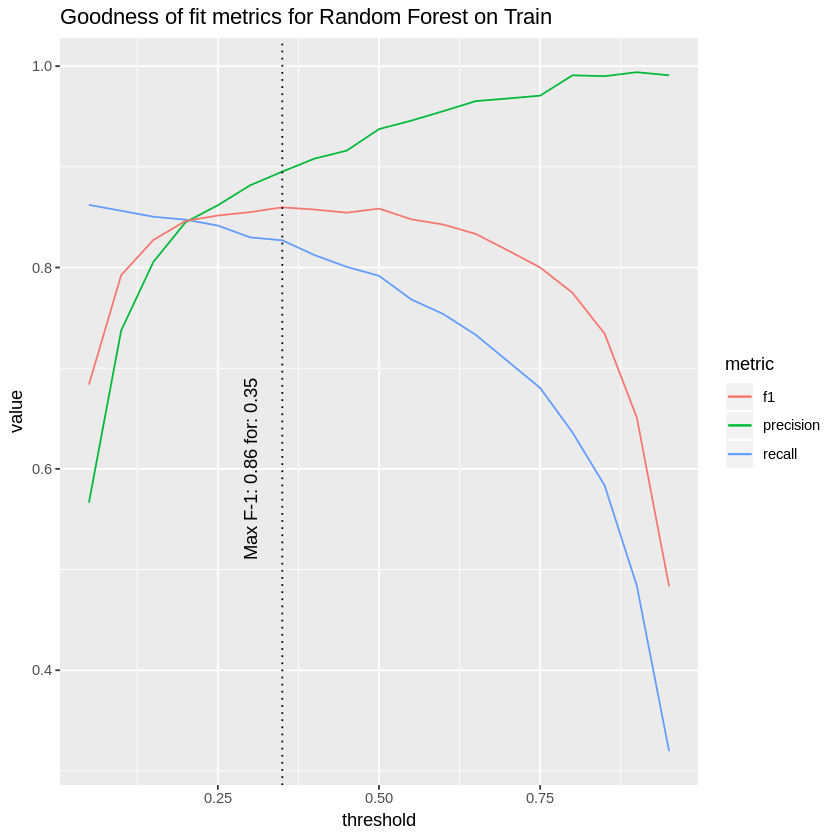

In [94]:
cutoff[['chart']]

Using this value on validation set: <br>
Recall: 80.13% <br>
Precision: 85.82% <br>
F-1: 82.88%

In [97]:
pred_only(feat_imp_rf,valid,opt_th)

   
        0     1
  0 96662    21
  1    30   121

The metrics on validation set are slightly worse than on training. Which is fine. The overfit is not significant. <br>
We could end the analysis of frauds on this model, however since RF models are kind of black-boxes, I wanted to research more intuitive way. <br>
Since, each transaction is a 30-dimensional vector with a specified class, we can imagine putting those vectors into some kind of a hyperplane. <br>
Intutively, we would say that frauds are closer to other frauds and far-away from legal transactions. <br>
Therefore, using pre-selected features from RF, I would try to fit a kNN model.

### kNN

First two components do not differ the transactions into the classess of interest. <br>
The below plot shows that first most important components in RF model definitely can somehow differ between the two classess. <br>
Since kNN is an algorithms requiring a lot of computational power, I will choose only those variables that have more than 40.0 on Mean Gini Decrease

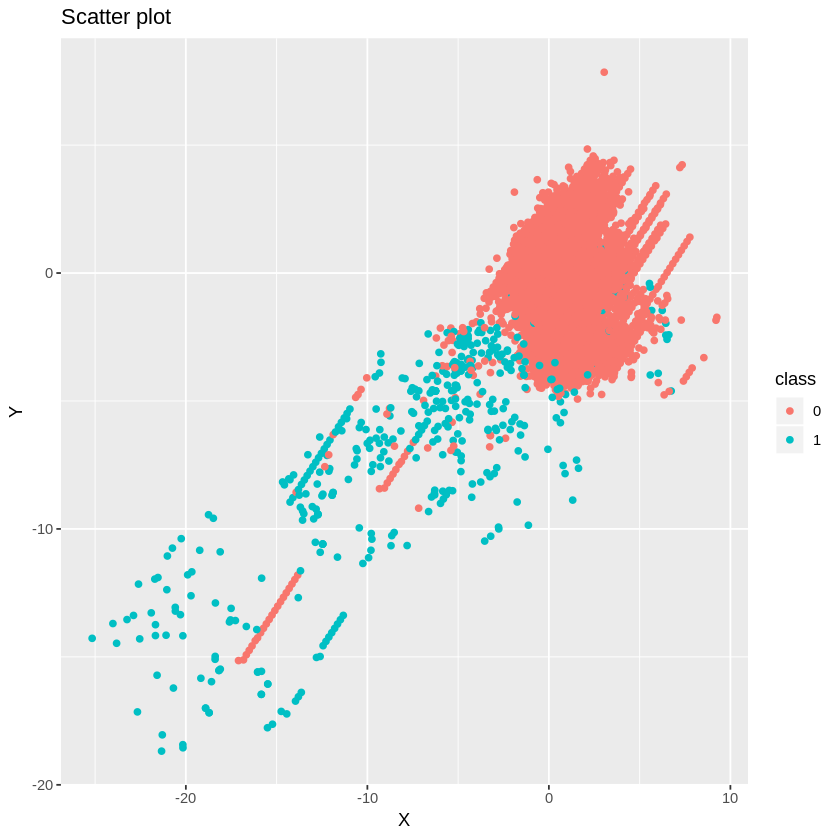

In [105]:
imp <- as.data.frame(feat_imp_rf$importance)
imp$var <- rownames(imp)
vars <- (imp %>% arrange(desc(MeanDecreaseGini)) %>% filter(MeanDecreaseGini > 40))$var

scatter(df,df$V17,df$V12,df$Class)

In order to specify number of neighbours that would be best choices basing on the data, I decided to do 10-fold cross validation. <br>
The aim is to find the n for maximizing the F-1 score.

Creating 10-fold subset of indexes for cross validation procedure.

In [151]:
cv_df_knn <- subset(df, select=c(vars))
cv_df_knn_y <- subset(df, select=Class)
cv_df_knn <- cbind(cv_df_knn, cv_df_knn_y)

folds <- createFolds(cv_df_knn$Class, k = 10, list = TRUE, returnTrain = FALSE)

Below scatter plot matrix shows all possible combinations of pre-selected variables. <br>
As it may be seen any of those combinations can dicriminate data into two fraud and non-fraud classes.

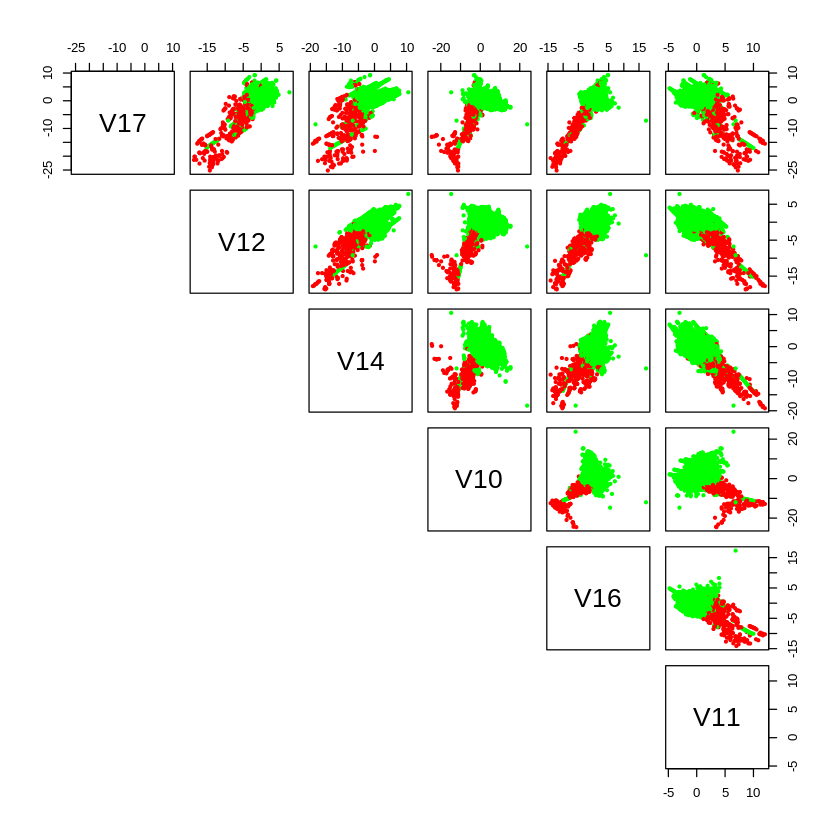

In [209]:
my_cols <- c("green", "red")  
pairs(cv_df_knn[,1:6], pch = 19,  cex = 0.5,
      col = my_cols[cv_df_knn$Class],
      lower.panel=NULL)

Doing the crossvalidation and reporting the goodness of fit metrics on validation set.

In [152]:
results <- cv_knn_train(folds, cv_df_knn, 10)

Formatting results form function into DataFrame.

In [155]:
df_cv <- as.data.frame(t(as.data.frame(results)),row.names = F)

Getting mean values for all runs of the CV.

In [158]:
means <- df_cv %>% group_by(k) %>% summarise_all(mean)
means

k,round,acc,rec,prc,f1
1,5.5,0.9993469,0.7762857,0.8358581,0.8039777
2,5.5,0.9992837,0.7682449,0.8085464,0.7872199
3,5.5,0.9995541,0.7805306,0.9528936,0.8577296
4,5.5,0.9995330,0.7785306,0.9404380,0.8513875
5,5.5,0.9995225,0.7805714,0.9326860,0.8491071
6,5.5,0.9995190,0.7744898,0.9360723,0.8468694
7,5.5,0.9995190,0.7764898,0.9342185,0.8473150
8,5.5,0.9995260,0.7805714,0.9348528,0.8496165
9,5.5,0.9995295,0.7805714,0.9364096,0.8504402
10,5.5,0.9995155,0.7764898,0.9310735,0.8460165


With 10-fold crossvalidation, the best performance is achieved when 3NN model is used.

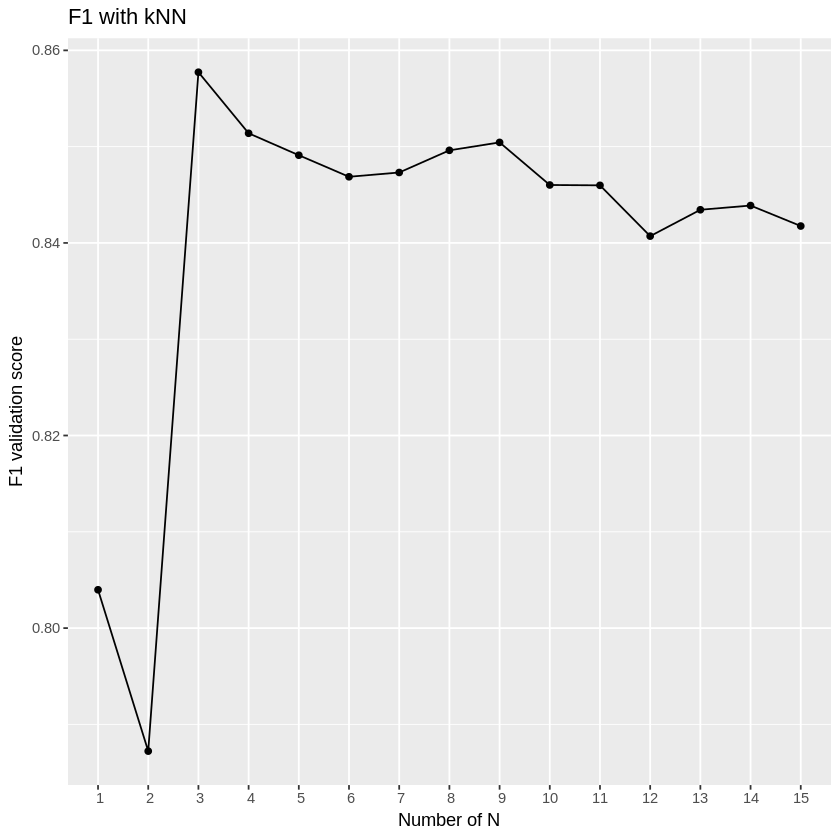

In [191]:
ggplot(means, aes(x=k))+
    geom_line(aes(y=f1))+
    geom_point(aes(y=f1))+
    scale_x_discrete(limits=c(1:15))+
    labs(title="F1 with kNN",x="Number of N",y="F1 validation score")

## Training final model: <br>

In [192]:
knn_train_y <- train$Class
knn_valid_y <- valid$Class

knn_train <- subset(train,select=vars) %>% mutate(Class=knn_train_y)
knn_valid <- subset(valid,select=vars) %>% mutate(Class=knn_valid_y)

In [193]:
valid3nn <- DMwR::kNN(Class~.,knn_train,knn_valid,k=3)
train3nn <- DMwR::kNN(Class~.,knn_train,knn_train,k=3)

In [196]:
valid_t <- table(knn_valid_y,valid3nn)
train_t <- table(knn_train_y,train3nn)

In [199]:
train_t

           train3nn
knn_train_y      0      1
          0 187623      9
          1     62    279

Training dataset measures: <br>
Recall: 81.82% <br>
Precision: 96.88% <br>
F1: 88.71%


In [197]:
valid_t

           valid3nn
knn_valid_y     0     1
          0 96669    14
          1    35   116

Validation dataset measures: <br>
Recall: 76.82% <br>
Precision: 89.23% <br>
F1: 82.56% <br>

kNN is performing similiarly to RF and is easier to comprehend and can be intuitvely explained, which is why I would recommend the use of kNN model in fraud detection.

### Fraud Amount prediction

Main obstacle is relatively small sample fo data for regression predictions. There are only 492 observation in whci we detect fraud. <br>
That is why, it is important to find out whether whole dataset can be used, i.e. whether there is significant difference of amounts between fraudulent and legal card transactions.

The histograms for both classes mostly overlaps. <br>
It means that somehow the Amount on fraud and legal transactions do not differ significantly.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


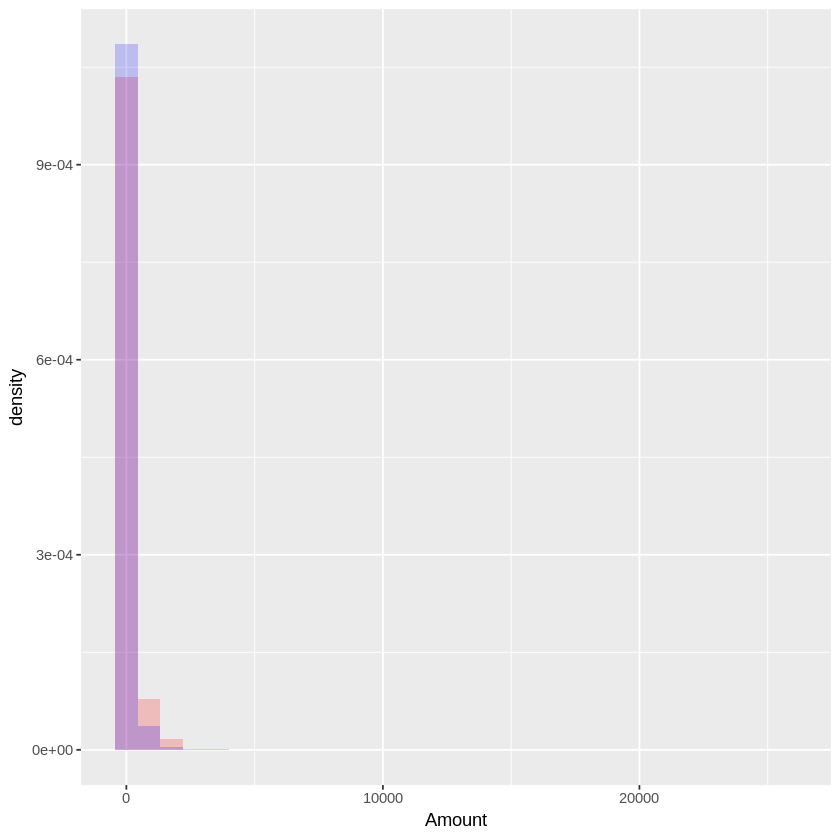

In [215]:
ggplot(df,aes(x=Amount)) + 
    geom_histogram(data=subset(df,Class == 1),aes(y=..density..),fill = "red", alpha = 0.2) +
    geom_histogram(data=subset(df,Class == 0),aes(y=..density..),fill = "blue", alpha = 0.2)

That is why I decided to train XgBoost Regression tree on whole dataset. <br>
I will train it on non-fraud transactions only and then check vs. randomly chosen 30% of legal transactions and 492 (all) fraud transaction.

In [8]:
fraud <- df %>% filter(Class==1)
legal <- df %>% filter(Class==0)

Creating seperate test dataset

In [9]:
test       <- rbind(fraud, legal %>% sample_frac(0.3))
test_class <- test$Class
test_y     <- test$Amount

train   <- anti_join(df, test, by='idx')
train_y <- train$Amount

test    <- subset(test, select=c(-Class,-Amount,-idx))
train   <- subset(train, select=c(-Class,-Amount,-idx))

Preparing XgBoost matrices

In [10]:
dtrain <- xgb.DMatrix(data=as.matrix(train), label=train_y)
dtest <- xgb.DMatrix(data=as.matrix(test),   label=test_y)

In [11]:
watchlist <- list(train=dtrain, test=dtest)

In [67]:
eta_levels = seq(0.05,0.5,0.05)
dep_levels = c(2:5)

Cross-validation procedure

In [68]:
cv_bst <- cv_xgb(eta_lvs = eta_levels,dep_lvs = dep_levels,data = dtrain,n = 5,round = 50)

[1]	train-rmse:260.058472+2.583210	test-rmse:260.047510+10.121135 
[2]	train-rmse:253.270920+2.423140	test-rmse:253.735913+10.186383 
[3]	train-rmse:246.848837+2.544730	test-rmse:247.454715+10.244969 
[4]	train-rmse:240.764801+2.524044	test-rmse:241.544732+10.473402 
[5]	train-rmse:235.190884+2.497305	test-rmse:236.188501+10.686244 
[6]	train-rmse:229.754452+2.555783	test-rmse:230.706790+10.869120 
[7]	train-rmse:224.609875+2.524030	test-rmse:225.800601+10.896989 
[8]	train-rmse:219.734912+2.512605	test-rmse:220.885528+11.260708 
[9]	train-rmse:215.194778+2.568683	test-rmse:216.567706+11.355015 
[10]	train-rmse:210.792108+2.587101	test-rmse:212.527490+11.545280 
[11]	train-rmse:206.563245+2.559407	test-rmse:208.769519+11.565242 
[12]	train-rmse:202.506339+2.583932	test-rmse:205.000067+11.572380 
[13]	train-rmse:198.648486+2.558497	test-rmse:201.423199+11.665989 
[14]	train-rmse:194.915054+2.553814	test-rmse:197.717362+11.991642 
[15]	train-rmse:191.364328+2.523573	test-rmse:194.441421+

In [80]:
eval_id <- seq(3,120,3)

In [192]:
test_results <- NULL
for (i in eval_id){
    res <- c(unlist((cv_bst[[i]][50,4])))
    test_results <- c(test_results, res)
}

In [193]:
train_results <- NULL
for (i in eval_id){
    res <- c(unlist((cv_bst[[i]][50,2])))
    train_results <- c(train_results, res)
}

Cross validation results are shown on the plot below. <br>
A visual check was used in order two get the combination with low RMSE on both sets as well as low difference between sets.

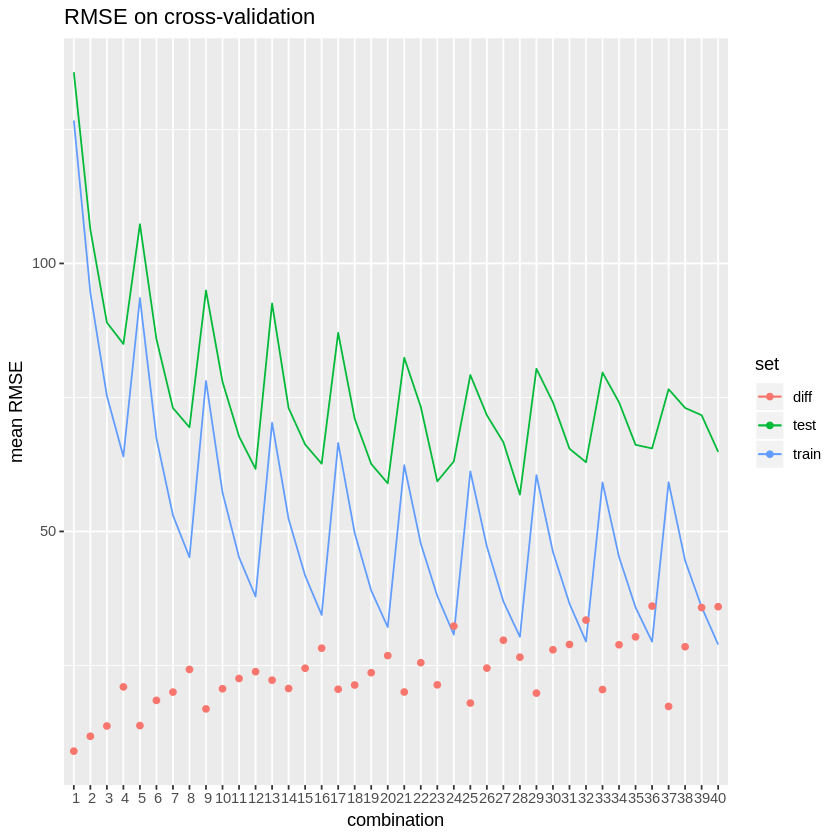

In [209]:
ggplot()+
    geom_line(aes(x=c(1:40),y=train_results,color="train"))+
    geom_line(aes(x=c(1:40),y=test_results,color="test"))+
    geom_point(aes(x=c(1:40),y=abs(train_results-test_results),color="diff"))+
    labs(color="set",title="RMSE on cross-validation",y="mean RMSE",x="combination")+
    scale_x_discrete(limits=c(1:40))

Combination no. 37 on the graph are the 109th, 110th, 111th elemts on the cross validation object result. <br>
Best performing cross-validation parameters are: <br>
<b> Depth </b>: 2 <br>
<b> Eta   </b>: 0.5

In [214]:
eval_id[37]

[1] 111

In [217]:
cv_bst[[109]]

[1] 2

In [218]:
cv_bst[[110]]

[1] 0.5

In [219]:
cv_bst[[111]]

iter,train_rmse_mean,train_rmse_std,test_rmse_mean,test_rmse_std
1,205.43856,3.9465249,209.11276,19.06175
2,173.83808,4.7509892,176.25737,17.24877
3,152.18828,3.0908645,157.11826,17.72341
4,136.94101,2.5472497,143.01514,18.04657
5,127.95319,2.6501598,135.52548,17.80815
6,120.87324,2.1922994,128.08781,15.21312
7,114.97178,1.6417059,122.47739,14.79515
8,109.99158,2.0809788,118.02143,14.59759
9,104.43165,1.3946399,113.26537,15.11006
10,100.12973,1.1507608,109.61290,16.13847


Fitting final model

In [220]:
bst <- xgb.train(data=dtrain, max.depth=2, eta=0.5, nthread=3,nround=50,
                 watchlist = watchlist,objective = "reg:linear")

[1]	train-rmse:203.928009	test-rmse:198.719254 
[2]	train-rmse:172.720871	test-rmse:174.100433 
[3]	train-rmse:150.912323	test-rmse:151.906326 
[4]	train-rmse:134.408081	test-rmse:136.132996 
[5]	train-rmse:124.056679	test-rmse:128.118347 
[6]	train-rmse:117.900162	test-rmse:122.585793 
[7]	train-rmse:109.622139	test-rmse:116.722633 
[8]	train-rmse:102.514885	test-rmse:110.019371 
[9]	train-rmse:98.398712	test-rmse:107.928284 
[10]	train-rmse:95.489342	test-rmse:105.460320 
[11]	train-rmse:93.323616	test-rmse:103.649918 
[12]	train-rmse:90.868340	test-rmse:101.965317 
[13]	train-rmse:88.370598	test-rmse:99.690376 
[14]	train-rmse:86.154503	test-rmse:97.738922 
[15]	train-rmse:84.580612	test-rmse:96.443588 
[16]	train-rmse:83.567963	test-rmse:96.109558 
[17]	train-rmse:81.854668	test-rmse:94.070999 
[18]	train-rmse:80.482056	test-rmse:92.615463 
[19]	train-rmse:78.658363	test-rmse:91.026909 
[20]	train-rmse:77.397156	test-rmse:89.657921 
[21]	train-rmse:76.708885	test-rmse:89.448807 
[2

After 5-10 iterations models begins to overfit.

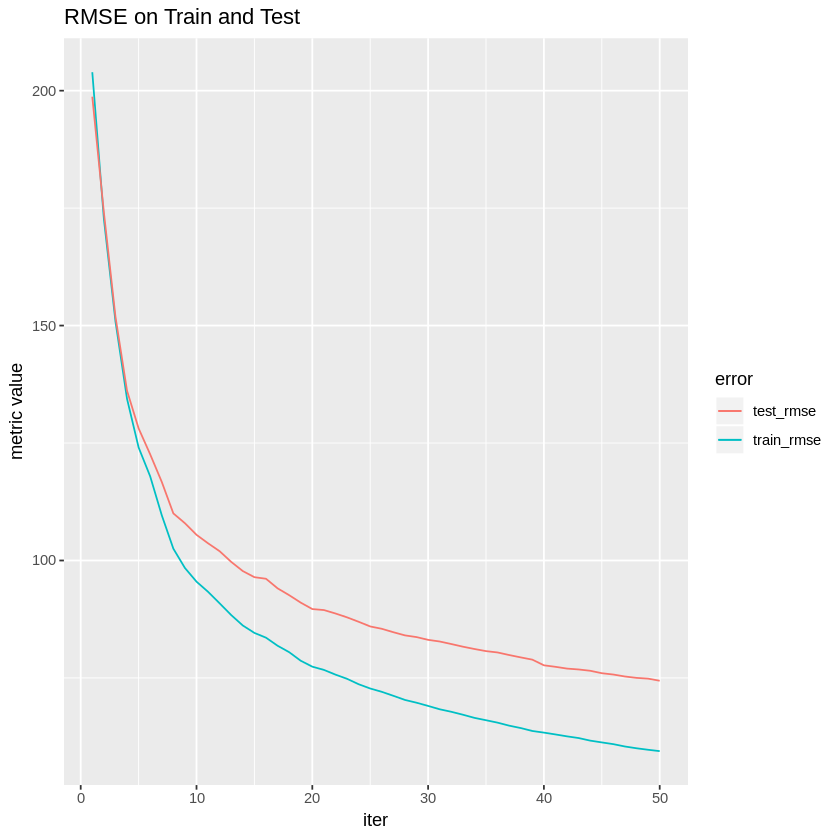

In [221]:
ggplot(bst$evaluation_log,aes(x=iter))+
    geom_line(aes(y=train_rmse,color='train_rmse'))+
    geom_line(aes(y=test_rmse,color='test_rmse'))+
    labs(y='metric value',title='RMSE on Train and Test',color="error")

Checking values on fraudulent transactions.

In [236]:
frauds <- test[test_class==1,]
f_preds <- predict(bst,as.matrix(frauds))
f_preds <- ifelse(f_preds < 0, 0, f_preds)

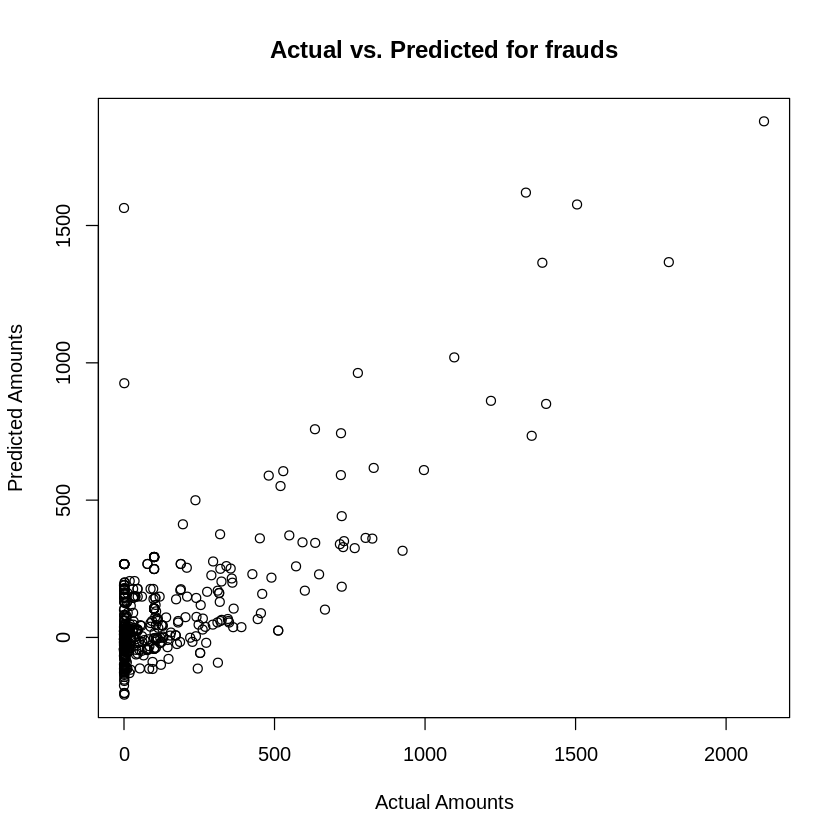

In [233]:
plot(test_y[test_class==1],f_preds, xlab="Actual Amounts",ylab="Predicted Amounts",main="Actual vs. Predicted for frauds")

RMSE on fraud transactions while being trained on non-fraud transaction is 163.57

In [237]:
RMSE(test_y[test_class==1],f_preds)

[1] 163.5714

R2 is 60.50%

In [238]:
R2(test_y[test_class==1],f_preds)

[1] 0.6050431

Inital results for this model are promising, however such high learning rate and quite an overfit are worrying. <br>
Further research is needed. Maybe, the model should be trained only on fraudulent transactions.